<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing:" data-toc-modified-id="Preprocessing:-1">Preprocessing:</a></span></li><li><span><a href="#Network-analysis:" data-toc-modified-id="Network-analysis:-2">Network analysis:</a></span></li><li><span><a href="#Maybe-for-later:" data-toc-modified-id="Maybe-for-later:-3">Maybe for later:</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import networkx as nx
from fa2 import ForceAtlas2

## Preprocessing:

In [2]:
df = pd.read_pickle('../Data/All_Friends_data.plk')

In [3]:
df.head(5)

,Speaker,Text,Episode,Scene
0,monica,"oh, the way you crushed mike at ping pong was...",1001,"[scene barbados, monica and chandler's room. t..."
1,chandler,"you know, i'd love to, but i'm a little tired.",1001,"[scene barbados, monica and chandler's room. t..."
2,monica,i'll put a pillowcase over my head.,1001,"[scene barbados, monica and chandler's room. t..."
3,chandler,you're on!,1001,"[scene barbados, monica and chandler's room. t..."
4,phoebe,hey!,1001,"[scene barbados, monica and chandler's room. t..."


In [4]:
# List of real names:
Names = nltk.corpus.names.words()
len(Names)

7944

In [5]:
# Speaking characters in all episodes:
# ( Excluding some wired ones..)
exclude = ['/',',',' and ',' to ','every','both','all','together','guys',' on ']
           #,'tape','tv','video','radio','machine','tape','message','etra','announcer','commercial']

Characters = []
for i in df.Speaker.unique():
    k=re.sub(r'\((.*)','',i)
    if k and any(x in k.capitalize() for x in Names) and not any(x in k for x in exclude) and len(k) < 20:
        if k[-1] == ' ': k = k[:-1] #If last character is a "space"
        Characters.append(k)

In [6]:
# List of all possible names that could be spoken about:
all_Names = list(np.unique(Characters + ['ugly naked guy','mon','rach','chan','joe','phoebs','pheebs']))
len(all_Names)

352

In [7]:
# Column for DataFrame with speaking or spoken characters:
# (Characters are added to being is the scene if they are speaking ore being spoken about)
Scene_Characters = []
for scene in list(df.Scene.unique()):
    # Characters speaking
    scene_char = [i for i in df[df.Scene == scene].Speaker.unique() if i in all_Names]
    # Charaters being spoken about:
    scene_char += [e for e in np.unique(sum([i.split(' ') for i in list(df[df.Scene == scene].Text)],[])) if e in all_Names]
    # Ectending column for DataFrame:
    Scene_Characters.extend([np.unique(scene_char)] * len(df[df.Scene == scene]))

In [8]:
# Adding column to dataframe:
df['Scene_characters'] = Scene_Characters
df.head()

,Speaker,Text,Episode,Scene,Scene_characters
0,monica,"oh, the way you crushed mike at ping pong was...",1001,"[scene barbados, monica and chandler's room. t...","[chandler, chandlers, charlie, joey, mike, mon..."
1,chandler,"you know, i'd love to, but i'm a little tired.",1001,"[scene barbados, monica and chandler's room. t...","[chandler, chandlers, charlie, joey, mike, mon..."
2,monica,i'll put a pillowcase over my head.,1001,"[scene barbados, monica and chandler's room. t...","[chandler, chandlers, charlie, joey, mike, mon..."
3,chandler,you're on!,1001,"[scene barbados, monica and chandler's room. t...","[chandler, chandlers, charlie, joey, mike, mon..."
4,phoebe,hey!,1001,"[scene barbados, monica and chandler's room. t...","[chandler, chandlers, charlie, joey, mike, mon..."


In [9]:
# Save for faster nect time:
df.to_pickle('../data/Dataset_with_all_scene_characters.pkl')

## Network analysis:

In [10]:
# df = pd.read_pickle('../data/Dataset_with_all_scene_characters.pkl')

In [16]:
E = list(df.Episode.unique())
df_season = df[df.Episode == E[4]].reset_index(drop = True)

In [17]:
G = nx.Graph()
for i in range(len(df_season)):
    for node in df_season.Scene_characters[i]:
        if node == 'chandlers': node = 'chandler' 
        if df_season.Speaker[i] in all_Names:
            #add edges:
            if G.has_edge(df_season.Speaker[i], node):
                w = G[df_season.Speaker[i]][node]['weight']
                G.add_edge(df_season.Speaker[i], node, weight = w + 1)    

            else:
                G.add_edge(df_season.Speaker[i], node, weight = 1)
G.remove_edges_from(G.selfloop_edges())

In [18]:
print(G.number_of_edges())
print(G.number_of_nodes())

194
25


In [19]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=0.001,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=2.0,

                        # Log
                        verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 6240.45it/s]


BarnesHut Approximation  took  0.06  seconds
Repulsion forces  took  0.17  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.03  seconds


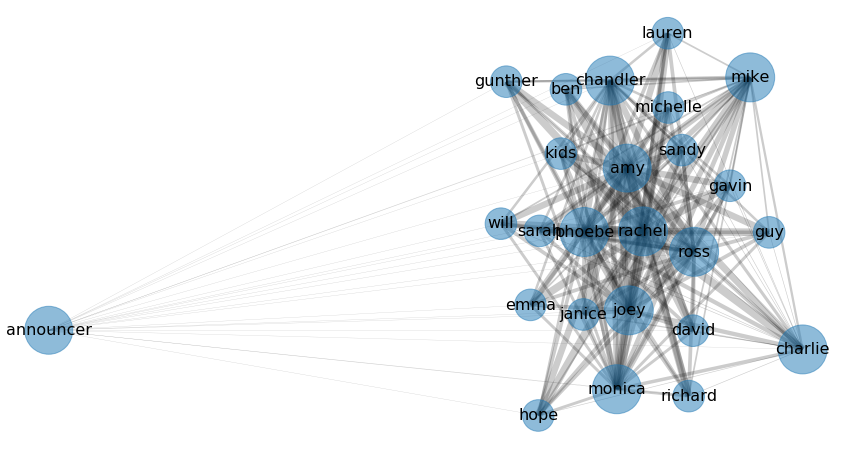

In [20]:
degrees = [list(G.degree)[i][1] for i in range(len(G))]
node_size = [i*100 for i in degrees]
edge_size = [i[2]['weight']/10 for i in G.edges(data=True)]
labels = dict(zip(list(G.nodes()),list(G.nodes())))

plt.figure(figsize=[15,8])

nx.draw_networkx_nodes(G, positions, node_size=node_size, with_labels=True, alpha=0.5)
nx.draw_networkx_edges(G, positions, width = edge_size, edge_color="black", alpha=0.2)
nx.draw_networkx_labels(G, positions, labels ,font_size=16)

plt.axis('off')
plt.show()

## Maybe for later: